In [1]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\Berne/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [2]:
# Download an example image
import urllib
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [3]:
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


input_image_py = Image.open(filename)
m, s = np.mean(input_image_py, axis=(0, 1)), np.std(input_image_py, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=m, std=s),
])
input_tensor = preprocess(input_image_py)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model = model.to('cuda')

with torch.no_grad():
    output_py = model(input_batch)


In [4]:
import cv2

input_image_py = np.array(input_image_py)

output_img_py = torch.round(output_py[0][0]).detach().numpy()
output_image_py = np.zeros((255,255,3))
for row_nr in range(0, 255):
    for col_nr in range(0, 255):
        output_image_py[row_nr][col_nr] = (input_image_py[row_nr][col_nr] * output_img_py[row_nr][col_nr])


In [5]:
# for row in input_image_py:
#     for pix in row:
#         for val in pix:
#             print(f"{val},", end="")

In [6]:
import numpy as np
input_array_cpp = []
with open("../bin/input_img.txt", "r")  as my_file:
    line = my_file.readline()
    for val in line.split(","):
        if val == "":
            continue
        input_array_cpp.append(int(np.round(float(val))))

input_image_cpp = np.array(input_array_cpp).reshape((256, 256, 3))

In [7]:
import numpy as np

output_array_cpp = []
with open("../bin/unet.output.txt", "r")  as my_file:
    line = my_file.readline()
    for val in line.split(","):
        if val == "":
            continue
        output_array_cpp.append(int(np.round(float(val))))

mask_cpp = np.array(output_array_cpp).reshape((256, 256))


In [8]:
input_image_cpp = np.array(input_image_cpp)


output_image_cpp = np.zeros((255,255,3))
for row_nr in range(0, 255):
    for col_nr in range(0, 255):
        output_image_cpp[row_nr][col_nr] = (input_image_cpp[row_nr][col_nr] * mask_cpp[row_nr][col_nr])

In [9]:
import torch
import onnxruntime as ort

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

# print(torch.__config__.show())
# print(model)
model.eval()
input_image_pyonnxx = torch.randn(1, 3, 256, 256)
input_image_pyonnxx = input_image_py
input_tensor = preprocess(input_image_py).reshape(1, 3, 256, 256)

onnx_program = torch.onnx.export(model, input_tensor, "../onnx/unet.onnx")
# onnx_program.save("unet.onnx")



ort_sess = ort.InferenceSession("../onnx/unet.onnx")

mask_pyonnxx = np.round(np.array(ort_sess.run(None, {'input.1': input_tensor.numpy()})).reshape((256, 256)))
print(mask_pyonnxx)

Using cache found in C:\Users\Berne/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
input_image_pyonnxx = np.array(input_image_pyonnxx).reshape((256, 256, 3))

output_image_pyonnxx = np.zeros((255,255,3))
for row_nr in range(0, 255):
    for col_nr in range(0, 255):
        output_image_pyonnxx[row_nr][col_nr] = (input_image_pyonnxx[row_nr][col_nr] * mask_pyonnxx[row_nr][col_nr])

Text(0.5, 1.0, 'py onnx output as mask over input img')

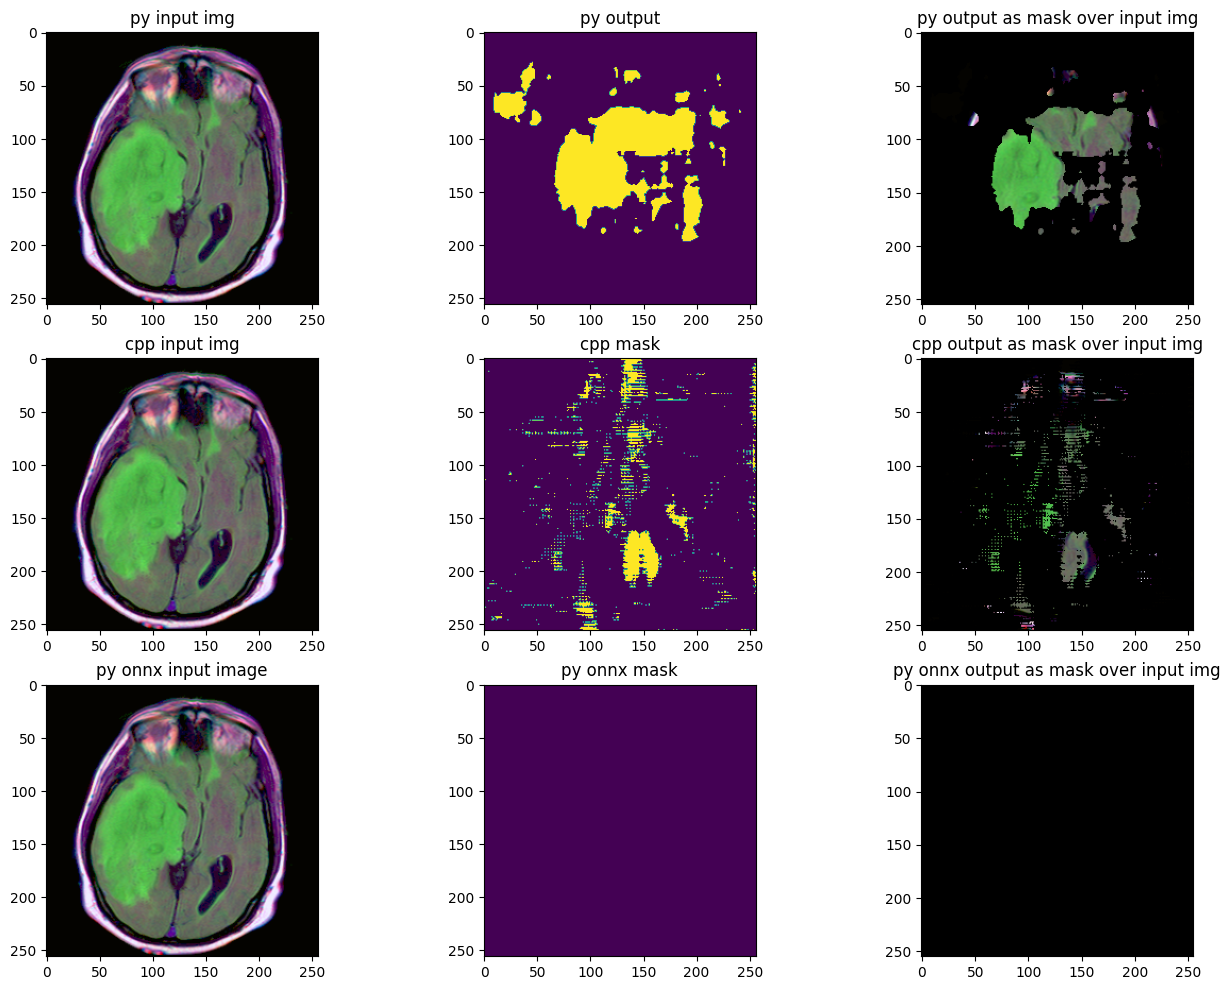

In [11]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(3, 3)
fig.set_figwidth(16)
fig.set_figheight(12)

ax[0][0].imshow(input_image_py.astype('uint8'))
ax[0][0].set_title("py input img")
ax[0][1].imshow(output_img_py.astype('uint8'))
ax[0][1].set_title("py output")
ax[0][2].imshow(output_image_py.astype('uint8'))
ax[0][2].set_title("py output as mask over input img")

ax[1][0].imshow(input_image_cpp.astype('uint8'))
ax[1][0].set_title("cpp input img")
ax[1][1].imshow(mask_cpp.astype('uint8'))
ax[1][1].set_title("cpp mask")
ax[1][2].imshow(output_image_cpp.astype('uint8'))
ax[1][2].set_title("cpp output as mask over input img")

ax[2][0].imshow(input_image_pyonnxx.astype('uint8'))
ax[2][0].set_title("py onnx input image")
ax[2][1].imshow(mask_pyonnxx.astype('uint8'))
ax[2][1].set_title("py onnx mask")
ax[2][2].imshow(output_image_pyonnxx.astype('uint8'))
ax[2][2].set_title("py onnx output as mask over input img")